In [1]:
from rdkit import Chem
from collections import Counter
import os
import pickle
import numpy as np
from collections import defaultdict

remake_dict = False

In [5]:
if remake_dict:
    #make a massive dict of all the brics substructures I guess?
    bigDict = {}
    bigDictSmiles = {}
    for name in os.listdir('brics'):
        mols = []
        smiles = []
        for substruct in os.listdir(f'brics/{name}/'):
            mol = Chem.MolFromMolFile(f'brics/{name}/{substruct}')
            if mol == None:
                continue
        
            mols.append(mol)
            smiles.append(Chem.MolToSmiles(mol))
        bigDict[name] = mols
        bigDictSmiles[name] = smiles



    #pickle these dictionaries bc they're fookin massive
    file = open('bigDict.pkl', 'wb')
    pickle.dump(bigDict, file)
    file.close()


    file2 = open('bigDictSmiles.pkl', 'wb')
    pickle.dump(bigDictSmiles, file2)
    file2.close()



#load big dicts
file = open('bigDict.pkl', 'rb')
bigDict = pickle.load(file)
file.close()


file2 = open('bigDictSmiles.pkl', 'rb')
bigDictSmiles = pickle.load(file2)
file2.close()

all_smiles = [item for sublist in list(bigDictSmiles.values()) for item in sublist]

#I don't really want to include molecules that are just one building block..

for n in list(bigDict.keys()):
    if len(bigDict[n]) == 1:
        del bigDict[n]
        del bigDictSmiles[n]

#rather than having a cutoff based on number of substructures included, use 'number of times appeared'
cnt = Counter(all_smiles)
most_common = [k for k, v in cnt.items() if v > 20]

safe = []
for sdf in bigDictSmiles.keys():
    #check if all of the smiles of the components are included in the most_common list...
    if all(item in most_common for item in bigDictSmiles[sdf]):
        safe.append(sdf)


#assign each smiles in most_common a 'charge'
smilesCharge = {}
counter = 0
for smiles in most_common:
    smilesCharge[smiles] = str(counter)
    counter = counter + 1


train = np.load('qm9/temp/qm9/actual_data/train.npz')
valid = np.load('qm9/temp/qm9/actual_data/valid.npz')
test = np.load('qm9/temp/qm9/actual_data/test.npz')

#make new train test and val npz files
# change both the position and the "charge" which will just be an index

safe_indices = [name[len(name)-6:len(name)] for name in safe]

In [12]:
file_names = train.files
mystery_indices = []
new_data = dict((el,[]) for el in file_names)
for index in final_safe_indices:
    #depends on the index: might be in the valid/ test sets
    if index in train['index']:
        split = train

    if index in test['index']:
        split = test


    if index in valid['index']:
        split = valid

    # look it up in the dataset
    for file in file_names:
        if file == 'num_atoms':
            #instead want it to be how many substructures
            new_data[file].append(len(bigDictSmiles[f'dsgdb9nsd_{str(index).zfill(6)}']))

        elif file == 'charges':
            for smiles in bigDictSmiles[f'dsgdb9nsd_{str(index).zfill(6)}']:
                charge = np.float(smilesCharge[smiles])
                new_data[file].append(charge)
        elif file == 'positions':
            #get centroid of substructure
            for molecule in bigDict[f'dsgdb9nsd_{str(index).zfill(6)}']:
                pos = []
                for i, atom in enumerate(molecule.GetAtoms()):
                    pos.append(np.array(molecule.GetConformer().GetAtomPosition(i)))
                centroid = np.mean(pos, axis=0)
                new_data[file].append(centroid)
                    
        else:
            #I don't think this is actually correct
            #need to get the index of the position not index of the compound
            try:
                new_data[file].append(split[file][list(split['index']).index(index)])
            except:
                mystery_indices.append(index)

In [14]:
prev = 0
list_indices=[]
for n in range(20):
    list_indices.append([prev, int(len(final_safe_indices)/20 + prev)])
    prev = int(len(final_safe_indices)/20 + prev) + 1

list_indices

[[0, 1748],
 [1749, 3497],
 [3498, 5246],
 [5247, 6995],
 [6996, 8744],
 [8745, 10493],
 [10494, 12242],
 [12243, 13991],
 [13992, 15740],
 [15741, 17489],
 [17490, 19238],
 [19239, 20987],
 [20988, 22736],
 [22737, 24485],
 [24486, 26234],
 [26235, 27983],
 [27984, 29732],
 [29733, 31481],
 [31482, 33230],
 [33231, 34979]]

In [24]:
import os
submit = True
if submit:

    with open('brics.sh') as template:
        lines = template.readlines()

    print(lines[1])

    for n in range(20):
        indices = list_indices[n]
        lines[1] = f'#SBATCH -J brics{indices[0]}_{indices[1]} #TITLE_TEMPALTE\n'
        lines[17] = f'python prepare_brics_data.py --index1 {indices[0]} --index2 {indices[1]}'

        f = open(f"brics_{indices[0]}_{indices[1]}.sh", 'w')
        for line in lines:
            f.write(line)
        f.close()
        
        os.system(f'sbatch brics_{indices[0]}_{indices[1]}.sh')
else:
    for n in range(18):
        os.system(f'scancel {99709 + n} -u vost -M srf_cpu_01')

#SBATCH -J pickle_dict_00000_01748 #TITLE_TEMPALTE



In [15]:
dicts = []
for indices in list_indices:
    file = open(f'processedWithBrics_{indices[0]}_{indices[1]}.pkl', 'rb')
    dict_current = pickle.load(file)
    dicts.append(dict_current)
    file.close()


In [90]:
dd = defaultdict(list)

for d in dicts: # you can list as many input dicts as you want here
    for key, value in d.items():
        dd[key].append(value)




In [91]:
new_data = dict(dd)

In [67]:
for key in new_data.keys():
    new_data[key] = [item for sublist in new_data[key] for item in sublist] 

In [93]:
len(new_data['charges'][0])

3469

In [88]:
train['charges'][0]

array([6, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0])

In [75]:
#also pickle this because it also takes ages
file = open('processedWithBrics.pkl', 'wb')
pickle.dump(new_data, file)
file.close()

In [17]:
#also pickle this because it also takes ages
file = open('processedWithBrics.pkl', 'rb')

new_data = pickle.load(file)

EOFError: Ran out of input

In [81]:
len(new_data['num_atoms'])

34961

In [72]:
#list(split['index']).index(
index in valid['index']

False

In [143]:
np.savez('train.npz', **new_data)
np.savez('test.npz', **new_data)
np.savez('valid.npz', **new_data)

(array([ 190., 1300.,  413.]),
 array([1, 2, 3, 4]),
 <BarContainer object of 3 artists>)

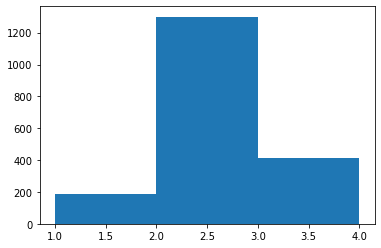

In [64]:
from matplotlib import pyplot as plt
plt.hist(new_data['num_atoms'], bins=[1,2,3,4])

Oc1ccc[nH]1


In [60]:
for smiles in smilesCharge:
    if len(smiles) == 0:
        print('AAAAAH')

In [149]:
np.load('qm9/temp/qm9/train.npz')['index'].shape

(1046,)

In [146]:
np.load('qm9/temp/qm9/actual_data/train.npz')['charges'].shape

(100000, 29)